# Imports

In [2]:
import glob
import zipfile
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from sklearn.metrics import f1_score
from tensorflow.keras.applications import MobileNetV2, MobileNet, EfficientNetB0, ResNet50, InceptionV3, VGG16
from tensorflow.keras import regularizers, initializers, Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, SpatialDropout2D, GlobalMaxPooling2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-12-06 12:48:59.148519: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 12:48:59.188902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 12:48:59.188946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 12:48:59.190394: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 12:48:59.197073: I tensorflow/core/platform/cpu_feature_guar

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

tf.config.set_visible_devices(gpus[1], 'GPU')  # Select GPU:1

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Hyperparameter for the model

In [4]:
batch_size = 24
target_size = (224, 224)
learning_rate = 0.0001
kernel_s = (3, 3)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Data Augmentation

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

train_gen=train_datagen.flow_from_directory(
    'Train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen=valid_datagen.flow_from_directory(
    'Validate',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_gen=valid_datagen.flow_from_directory(
    'Test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 6400 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


# Plotting a batch of training data

['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']


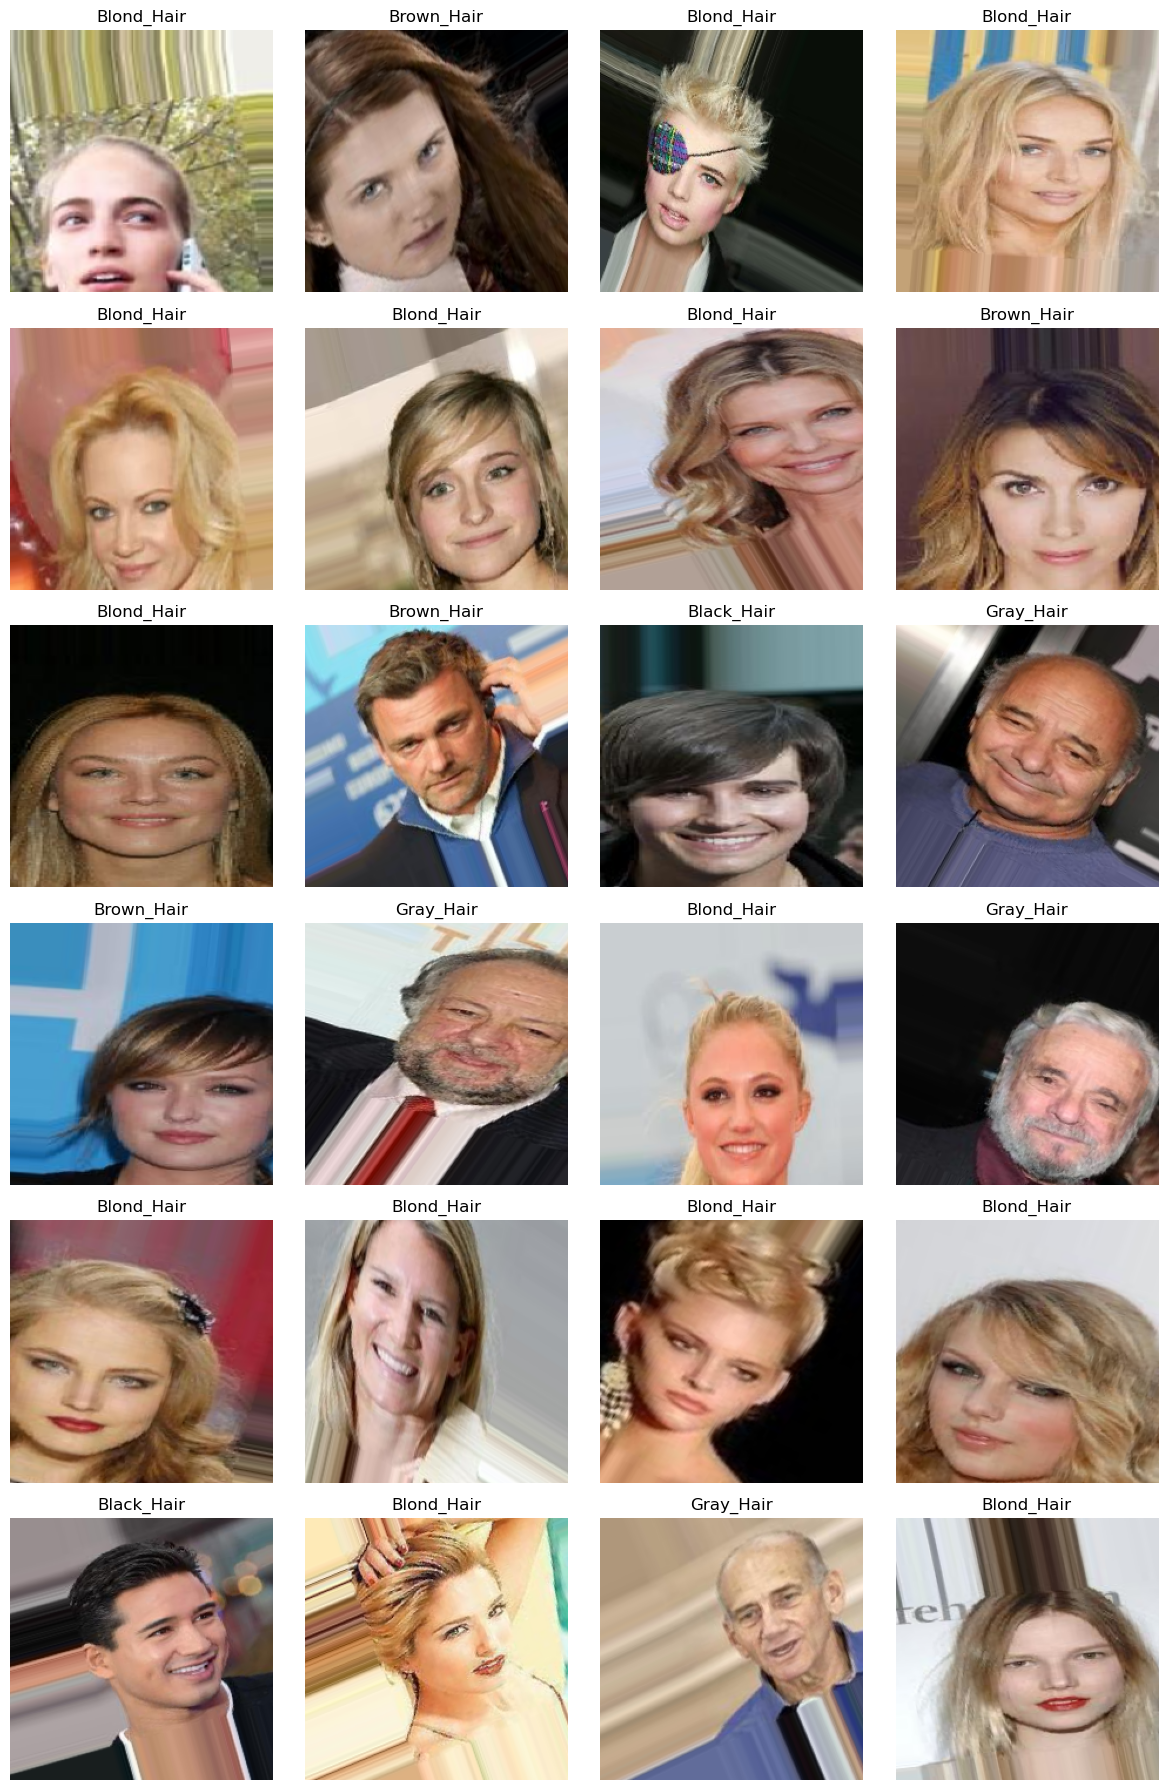

In [6]:
x_batch, y_batch = next(train_gen)
num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

class_labels = list(train_gen.class_indices.keys())  # ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']
print(class_labels)

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])
    
    class_index = y_batch[i].argmax()
    label = class_labels[class_index]
    
    ax.set_title(label)
    ax.axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Set up and configure a model for training

In [17]:
# These two models are also not bad
# base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Is correct on the test data, but not on my own
# base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Works for my images, but isn't correct on the test data

# https://arxiv.org/abs/1409.4842 - Paper of the Inception architecture
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False 

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.summary()

2024-12-01 14:26:20.334316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46388 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:73:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1024)              52429824  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 74236708 (283.19 MB)
Trainable params: 59607236 (227.38 MB)
Non-trainable params: 14629472 (55.81 MB)
_________________________________________________________________


# Compile the model and start the training

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(
    train_gen,
    batch_size=batch_size,
    epochs=40,
    validation_data=valid_gen,
    steps_per_epoch=100,
    callbacks=[early_stopping]
)

Epoch 1/40


2024-12-01 14:26:33.847826: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-12-01 14:26:36.906866: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6e24d15200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-01 14:26:36.906923: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-12-01 14:26:36.920400: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733063197.076847   66625 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 40s 278ms/step - loss: 3.7360 - acc: 0.6062 - val_loss: 0.5205 - val_acc: 0.7962
Epoch 2/40
100/100 [==============================] - 22s 224ms/step - loss: 0.6091 - acc: 0.7646 - val_loss: 0.4112 - val_acc: 0.8363
Epoch 3/40
100/100 [==============================] - 22s 223ms/step - loss: 0.5323 - acc: 0.7943 - val_loss: 0.4540 - val_acc: 0.8238
Epoch 4/40
100/100 [==============================] - 22s 221ms/step - loss: 0.5027 - acc: 0.8140 - val_loss: 0.4844 - val_acc: 0.8213
Epoch 5/40
100/100 [==============================] - 23s 225ms/step - loss: 0.4999 - acc: 0.8158 - val_loss: 0.3955 - val_acc: 0.8575
Epoch 6/40
100/100 [==============================] - 22s 223ms/step - loss: 0.4514 - acc: 0.8229 - val_loss: 0.3382 - val_acc: 0.8788
Epoch 7/40
100/100 [==============================] - 22s 222ms/step - loss: 0.4545 - acc: 0.8346 - val_loss: 0.3380 - val_acc: 0.8637
Epoch 8/40
100/100 [==============================] - 22s 223ms/st

# Plot the results of the training

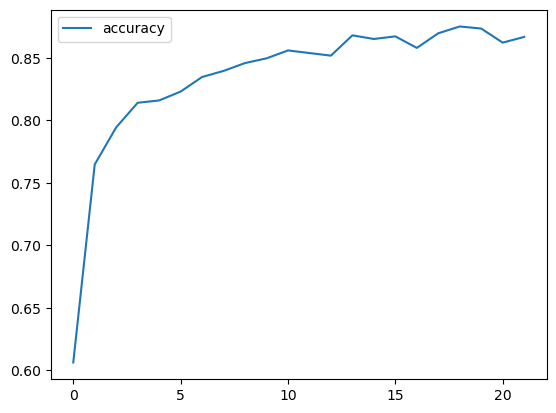

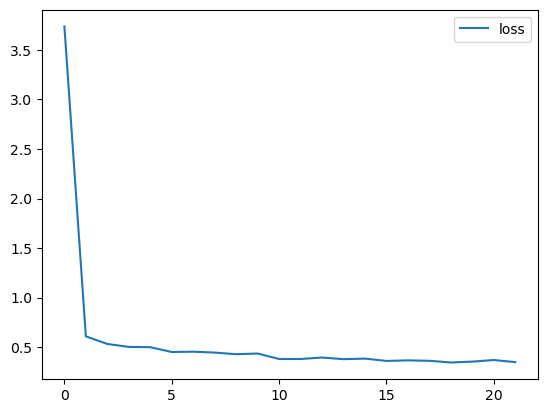

In [20]:
plt.plot(history.history['acc'], label='accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.legend()

# Test the model on the test data

1/1 [==============================] - 1s 1s/step


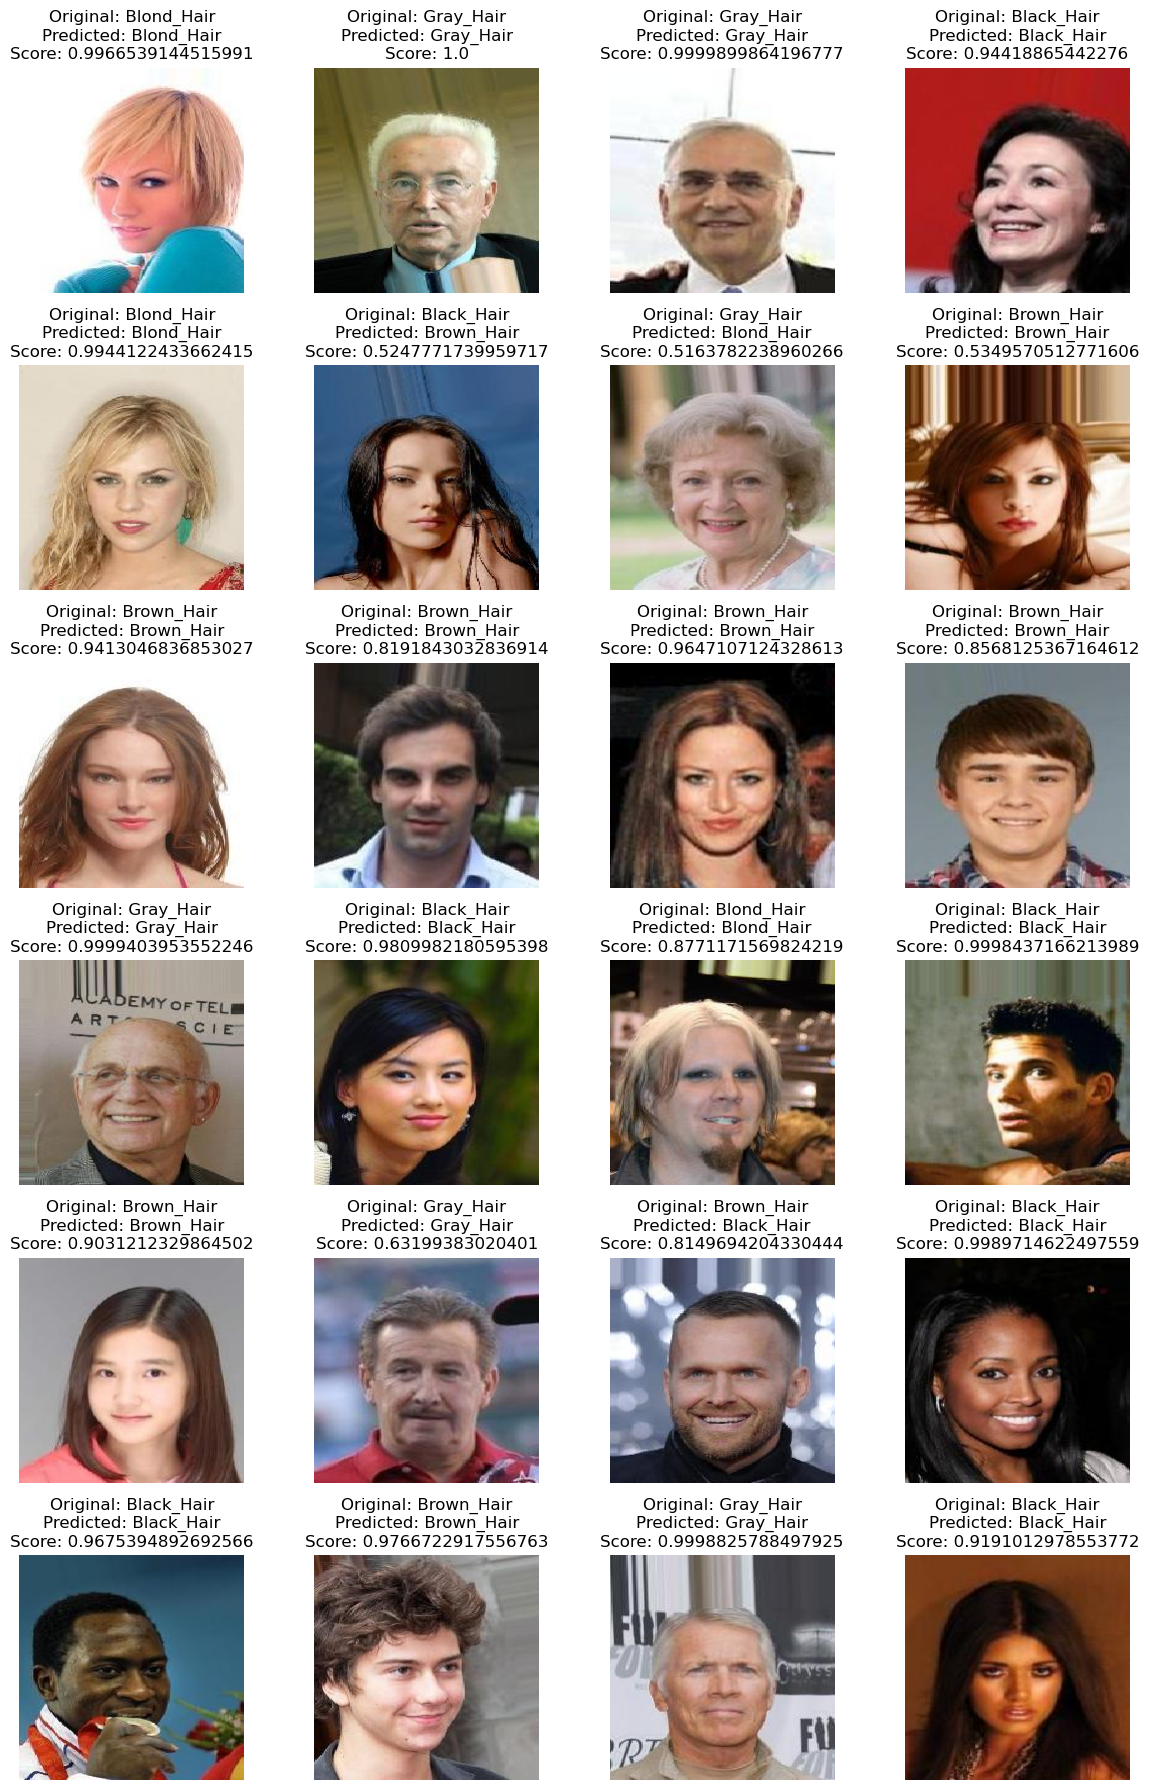

In [21]:
x_batch, y_batch = next(test_gen)
predictions = model.predict(x_batch)

predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_batch, axis=1)

class_names = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Gray_Hair"]

num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])

    true_label = class_names[true_labels[i]]
    predicted_label = class_names[predicted_labels[i]]
    prediction_score = predictions[i][predicted_labels[i]]

    ax.set_title(f"Original: {true_label}\nPredicted: {predicted_label}\nScore: {prediction_score}")
    ax.axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Test the model on my own data

1/1 [==============================] - 1s 1s/step


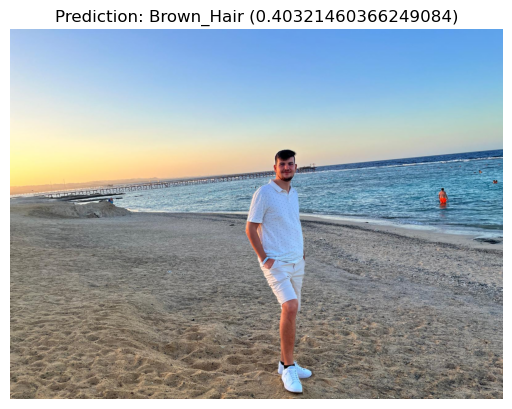

1/1 [==============================] - 0s 35ms/step


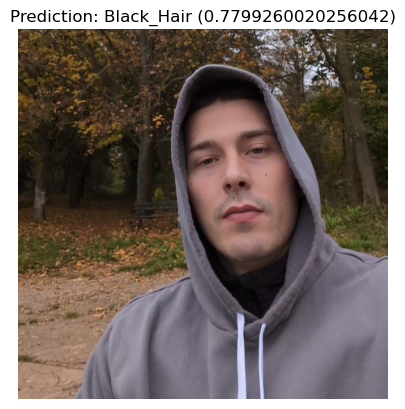

1/1 [==============================] - 0s 34ms/step


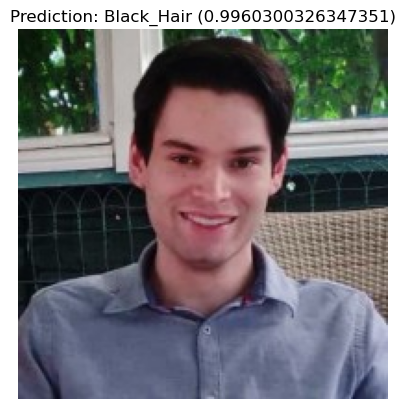

1/1 [==============================] - 0s 28ms/step


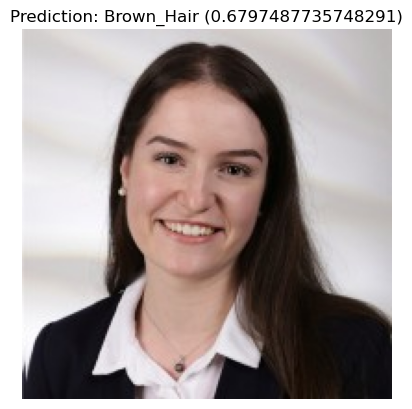

1/1 [==============================] - 0s 33ms/step


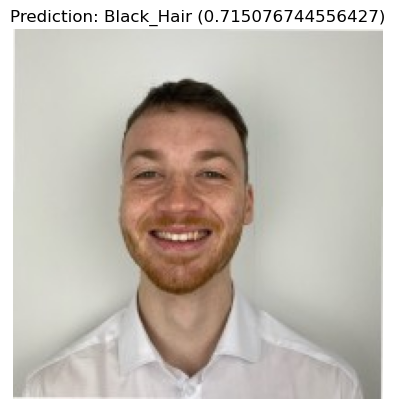

1/1 [==============================] - 0s 33ms/step


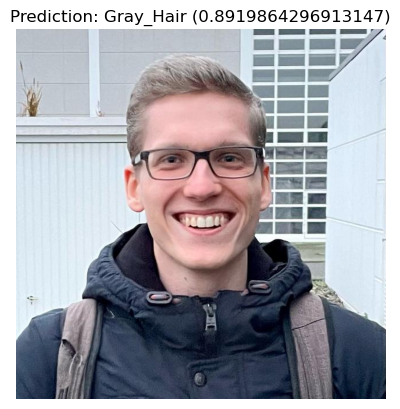

In [22]:
def edit_image(image_path: str) -> np.array: 
    img = load_img(image_path, target_size=target_size)

    img_array = img_to_array(img)
    img_array = img_array / 255.0 

    img_array = np.expand_dims(img_array, axis=0)

    return img_array

class_names = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Gray_Hair"]

images = glob.glob('../Images/*.jpg')

for i, image in enumerate(images):
        img_array = edit_image(image)

        prediction = model.predict(img_array)

        predicted_label_index = np.argmax(prediction, axis=1)[0]
        predicted_label = class_names[predicted_label_index]
        confidence = prediction[0][predicted_label_index]

        plt.imshow(load_img(image))
        plt.title(f"Prediction: {predicted_label} ({confidence:})")
        plt.axis("off")
        plt.show()

# Evaluate the model ans save it to a file

In [23]:
model.evaluate(test_gen)
model.save("../Models/Haircolor_classification.keras")

34/34 [==============================] - 2s 48ms/step - loss: 0.3588 - acc: 0.8725
